In [ ]:
!git clone -b stable https://github.com/pelancha/galaxyHackers/

Cloning into 'galaxyHackers'...
remote: Enumerating objects: 760, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 760 (delta 38), reused 26 (delta 25), pack-reused 701 (from 1)
Receiving objects: 100% (760/760), 3.73 MiB | 20.42 MiB/s, done.
Resolving deltas: 100% (461/461), done.


In [ ]:
!pip -q install gdown

In [ ]:
!pip -q install torch torchvision timm torch_optimizer wandb tqdm
!pip -q install numpy pandas matplotlib scikit-learn
!pip -q install Pillow astropy astroquery pixell
!pip -q install dynaconf wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
%cd galaxyHackers/

/content/galaxyHackers


In [ ]:
import os

In [ ]:
os.makedirs("storage", exist_ok = True)

In [ ]:
%cd storage/

/content/galaxyHackers/storage


In [ ]:
!unzip -qq allData.zip

In [ ]:
!rm -R allData.zip

In [ ]:
%cd ..

/content/galaxyHackers


In [ ]:
!ls

config.py	   main.py     models	       README.md	settings.py    storage
data.py		   Makefile    notebooks       screenshots	settings.toml  train.py
legacy_for_img.py  metrics.py  pyproject.toml  segmentation.py	setup.cfg


In [ ]:
import os

import torch

import argparse
# import wandb

from config import settings


import data
from data import DataPart
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
datasets, dataloaders = data.create_dataloaders()

In [ ]:
from tqdm import tqdm
min_channel = torch.Tensor([np.inf, np.inf])

for img in tqdm(datasets[DataPart.TRAIN]):

    name, img = img["idx"], img["image"]

    img_min = torch.min(img.view(img.shape[0], -1), dim=1)[0]

    # Detecting outlier image
    if img_min[0] < -351:
        error_message = (f"\nOutlier detected:\n"
                         f"  Image ID: {name}\n"
                         f"  Minimum value: {img_min[0]:.6f}")
        print(error_message)
        break

    min_channel = torch.min(min_channel, img_min)

  6%|▌         | 286/5034 [00:04<01:10, 67.82it/s]


Outlier detected:
  Image ID: 286
  Minimum value: -351.557129


In [ ]:
# Sorting to get minimal possible values in outlier
sorted(img[1].ravel().numpy())

In [ ]:
import numpy as np
from astropy.io import fits

import torch

images = []
average_image = None
global_min = torch.Tensor([np.inf, np.inf])
for i in range(100):
    with fits.open(f'storage/data/train/{i}.fits') as hdul:

        img = torch.Tensor(hdul[0].data.astype(np.float64))
        images.append(img)
        if average_image is None:
            average_image = img
        else:
            average_image += img

        img_min = torch.min(img.view(img.shape[0], -1), dim=1)[0]
        global_min = torch.min(global_min, img_min)

average_image = average_image / 100

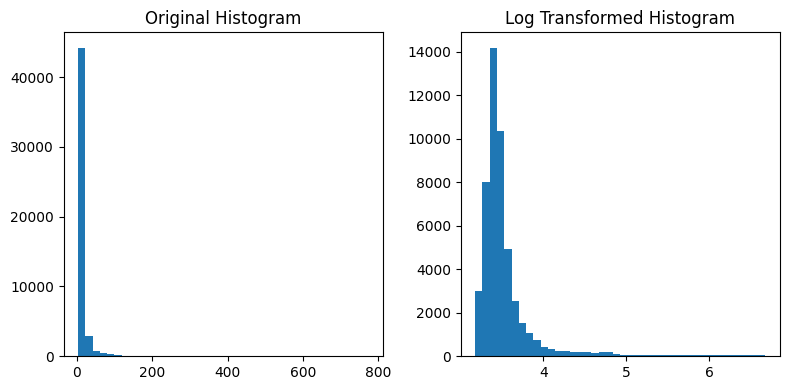

In [ ]:
import time
import matplotlib.pyplot as plt

def plot_histograms_in_loop(images, channel=1):
    for img in images:
        fig = plt.figure(figsize=(8, 4))  # Set the figure size

        # First histogram
        plt.subplot(1, 2, 1)
        plt.hist(img[channel].ravel(), bins=40)
        plt.title('Original Histogram')

        # Second histogram with log transformation
        plt.subplot(1, 2, 2)
        plt.hist(np.log(img[channel].ravel() - global_min[channel] + 0.1), bins=40)
        plt.title('Log Transformed Histogram')

        plt.tight_layout()  # Adjust subplots to fit in to the figure area.
        plt.show()

        #time.sleep(1)  # Pause for 1 second

        plt.close(fig)

#plot_histograms_in_loop(images) #comment it
plot_histograms_in_loop([average_image])

In [ ]:
import torch
import numpy as np
from astropy.io import fits

def load_fits_channels(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[0].data.astype(np.float64)
        channel_1 = torch.tensor(data[0, :, :], dtype=torch.float32)
        channel_2 = torch.tensor(data[1, :, :], dtype=torch.float32)
    return channel_1, channel_2

file_paths = [f'storage/data/train/{i}.fits' for i in range(100)]

mean = [0.0, 0.0]
std = [0.0, 0.0]
n_files = len(file_paths)

for file_path in file_paths:
    channel_1, channel_2 = load_fits_channels(file_path)
    mean[0] += channel_1.mean().item()
    mean[1] += channel_2.mean().item()

    std[0] += channel_1.std().item()
    std[1] += channel_2.std().item()

mean[0] /= n_files
mean[1] /= n_files
std[0] /= n_files
std[1] /= n_files

transform = transforms.Compose([
    transforms.Normalize(mean=mean, std=std)
])


In [ ]:
print(mean, std)

[23.19058950345032, 22.780995295792817] [106.89880134344101, 100.32284196853638]


In [ ]:
def print_distr(img, normalized_image):
    normalized_image_np = normalized_image.numpy()
    original_channel_1 = img[0, :, :].numpy()
    original_channel_2 = img[1, :, :].numpy()

    normalized_channel_1 = normalized_image_np[0, :, :]
    normalized_channel_2 = normalized_image_np[1, :, :]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Оригиналы
    axs[0, 0].hist(original_channel_1.flatten(), bins=100, color='blue', alpha=0.7)
    axs[0, 0].set_title('Original distribution channel 1')

    axs[1, 0].hist(original_channel_2.flatten(), bins=100, color='green', alpha=0.7)
    axs[1, 0].set_title('Original distribution channel 2')

    # После нормализации
    axs[0, 1].hist(normalized_channel_1.flatten(), bins=100, color='red', alpha=0.7)
    axs[0, 1].set_title('Normalized distribution channel 1')

    axs[1, 1].hist(normalized_channel_2.flatten(), bins=100, color='purple', alpha=0.7)
    axs[1, 1].set_title('Normalized distribution channel 2')


    plt.tight_layout()
    plt.show()


In [ ]:
def print_imgs(img, normalized_image):

    normalized_image_np = normalized_image.numpy()

    original_channel_1 = img[0, :, :].numpy()
    original_channel_2 = img[1, :, :].numpy()

    normalized_channel_1 = normalized_image_np[0, :, :]
    normalized_channel_2 = normalized_image_np[1, :, :]


    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Оригиналы
    axs[0, 0].imshow(original_channel_1, cmap='gray')
    axs[0, 0].set_title('Original channel 1')
    axs[1, 0].imshow(original_channel_2, cmap='gray')
    axs[1, 0].set_title('Original channel 2')

    # После нормализации
    axs[0, 1].imshow(normalized_channel_1, cmap='gray')
    axs[0, 1].set_title('Normalized channel 1')
    axs[1, 1].imshow(normalized_channel_2, cmap='gray')
    axs[1, 1].set_title('Normalized channel 2')


    for ax in axs.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Распределение 0го изображения

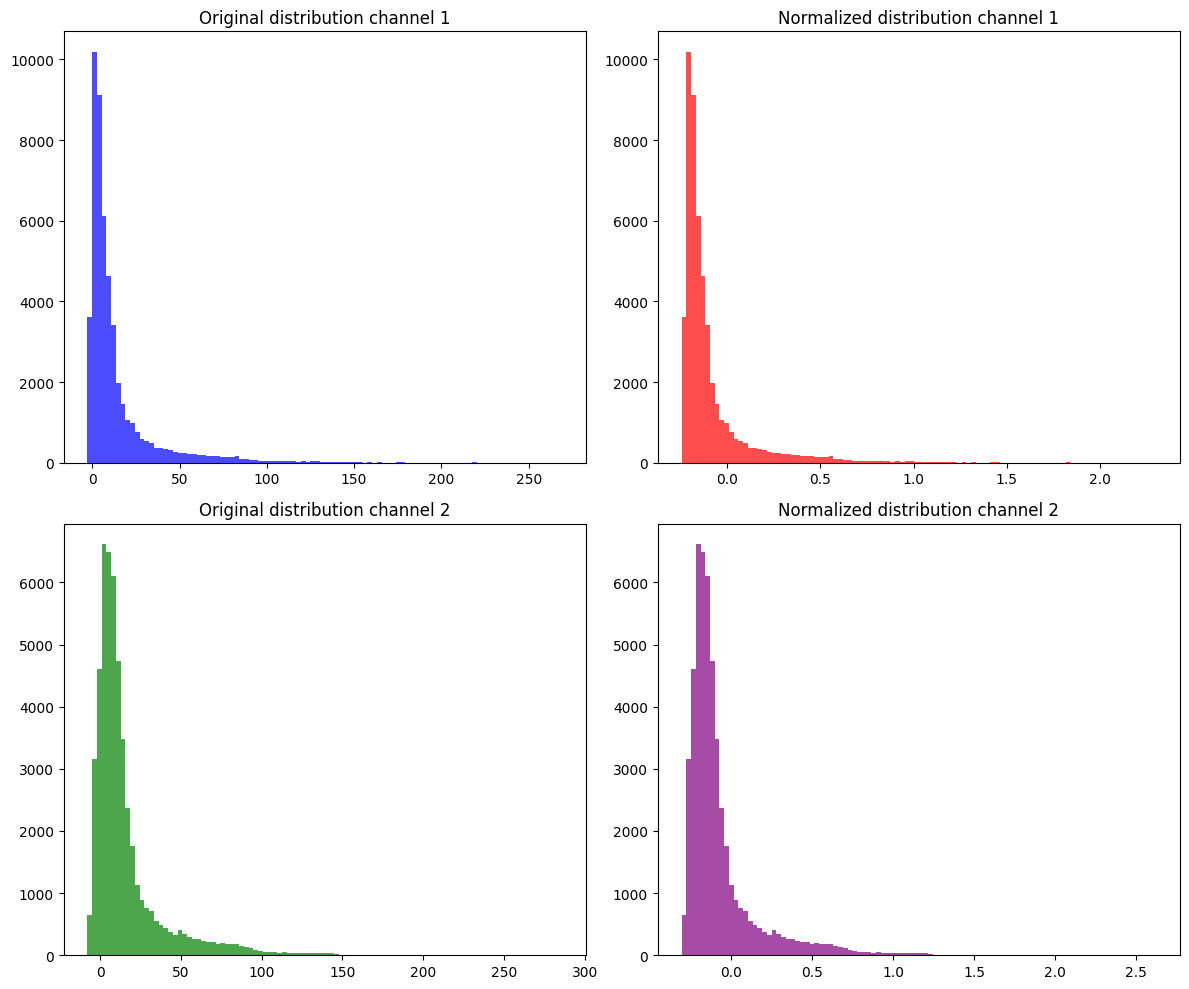

In [ ]:
channel_1, channel_2 = load_fits_channels(file_paths[0])
img = torch.stack([channel_1, channel_2])
normalized_image = transform(img)

print_distr(img, normalized_image)

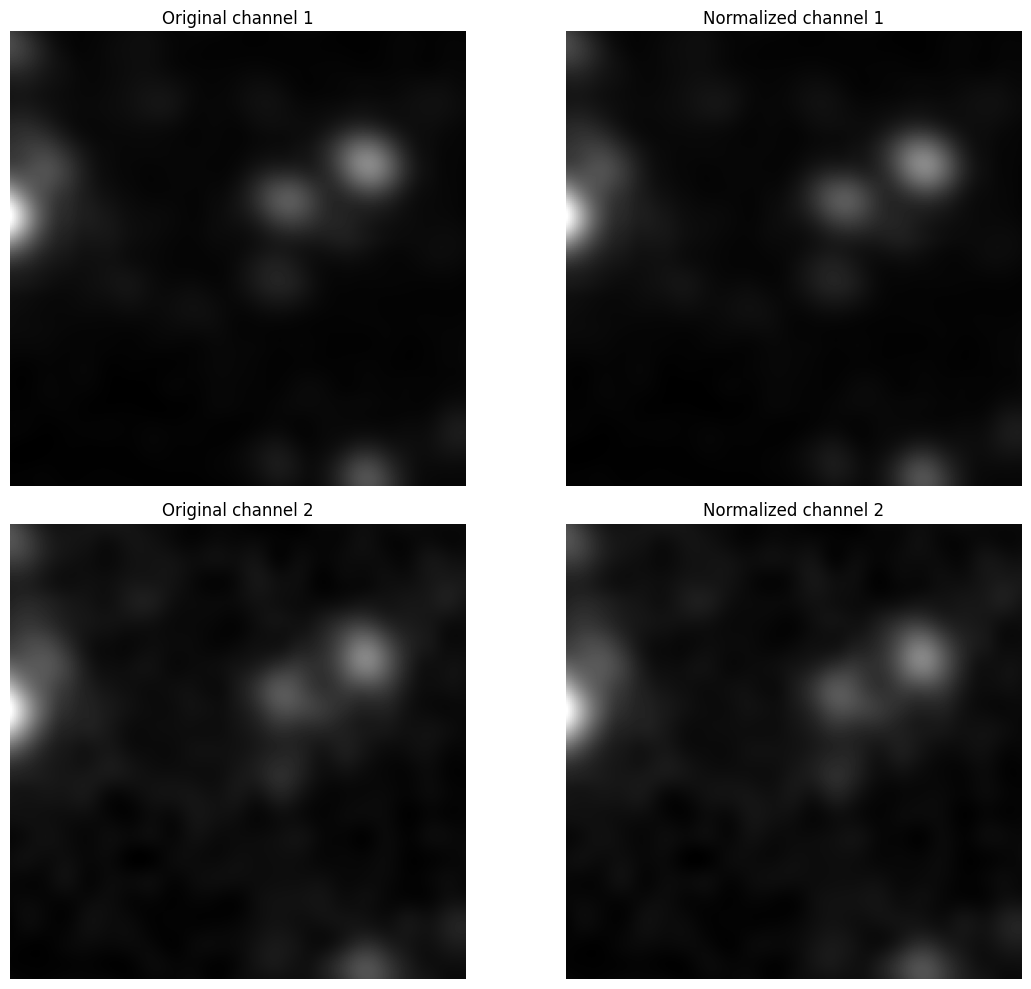

In [ ]:
print_imgs(img, normalized_image)

Распределение 2го изображения

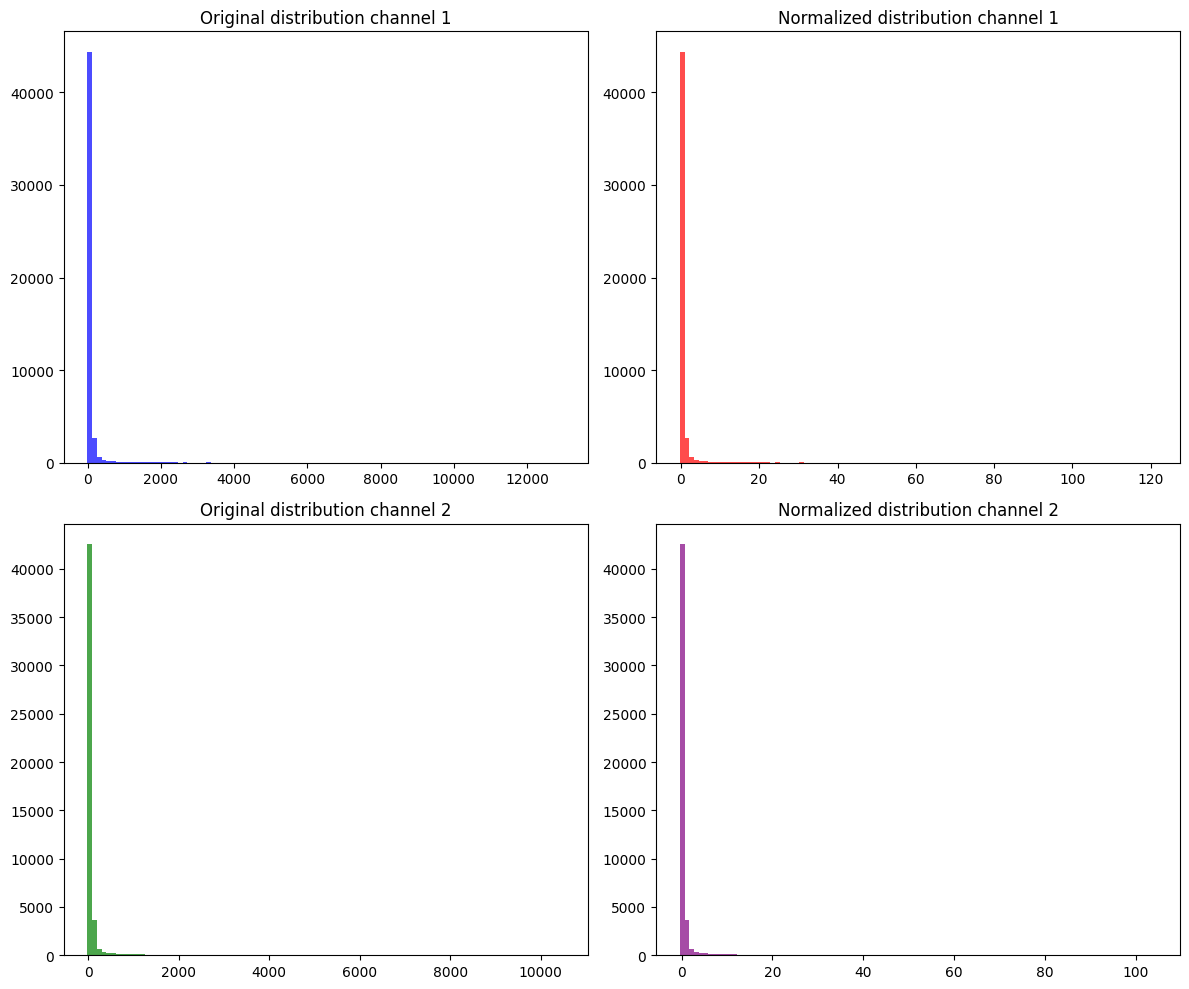

In [ ]:
channel_1, channel_2 = load_fits_channels(file_paths[2])
img = torch.stack([channel_1, channel_2])
normalized_image = transform(img)

print_distr(img, normalized_image)

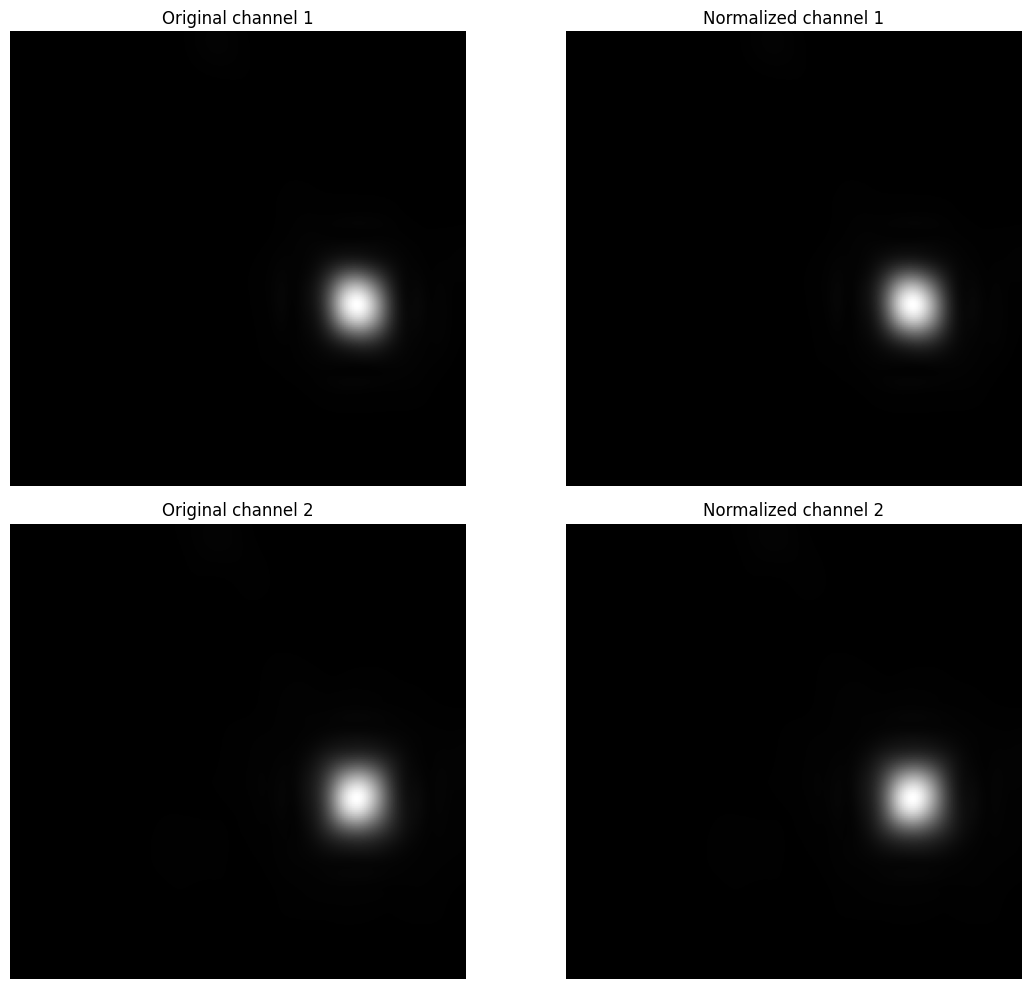

In [ ]:
print_imgs(img, normalized_image)

Распределение 4го изображения

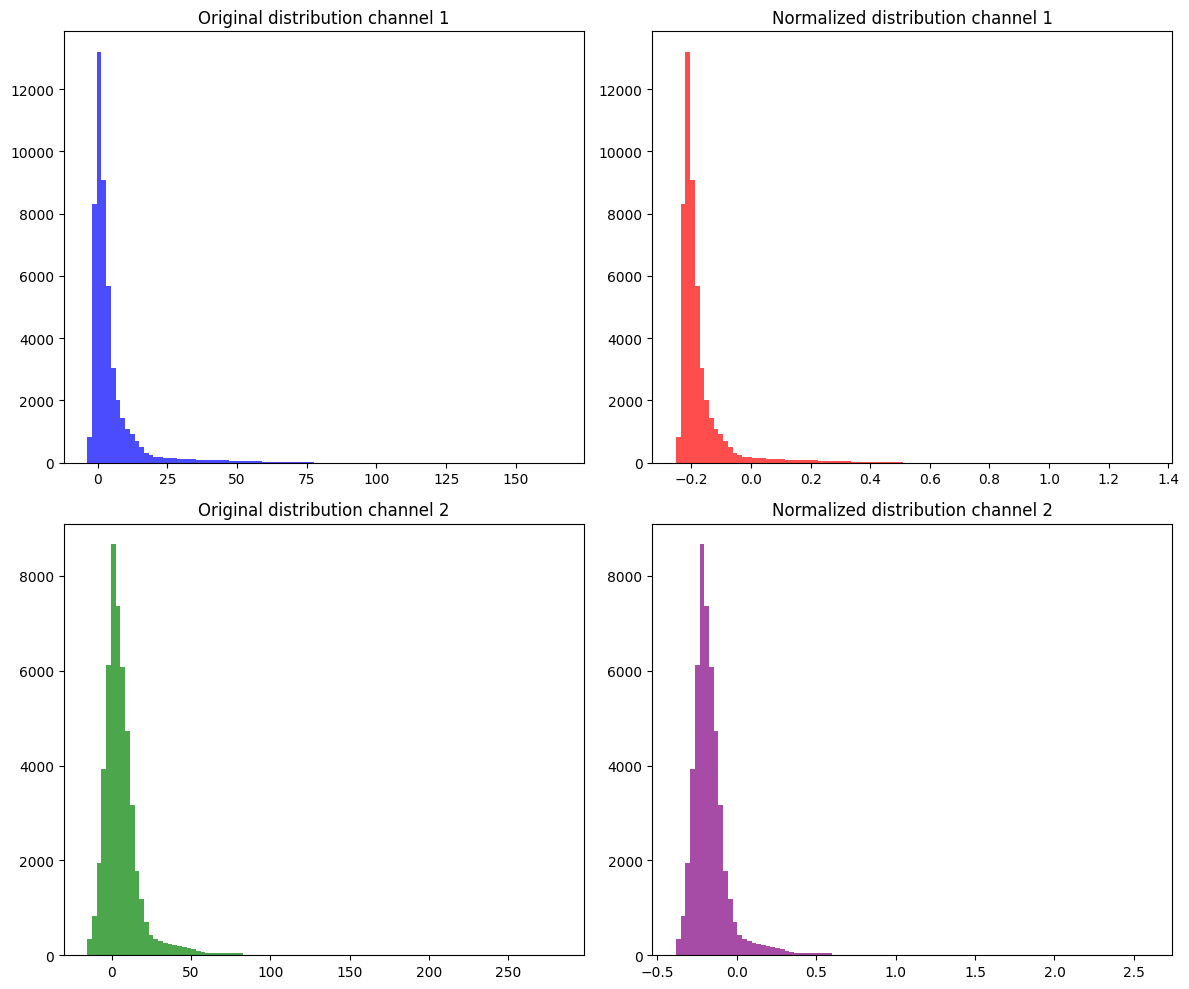

In [ ]:
channel_1, channel_2 = load_fits_channels(file_paths[3])
img = torch.stack([channel_1, channel_2])
normalized_image = transform(img)

print_distr(img, normalized_image)

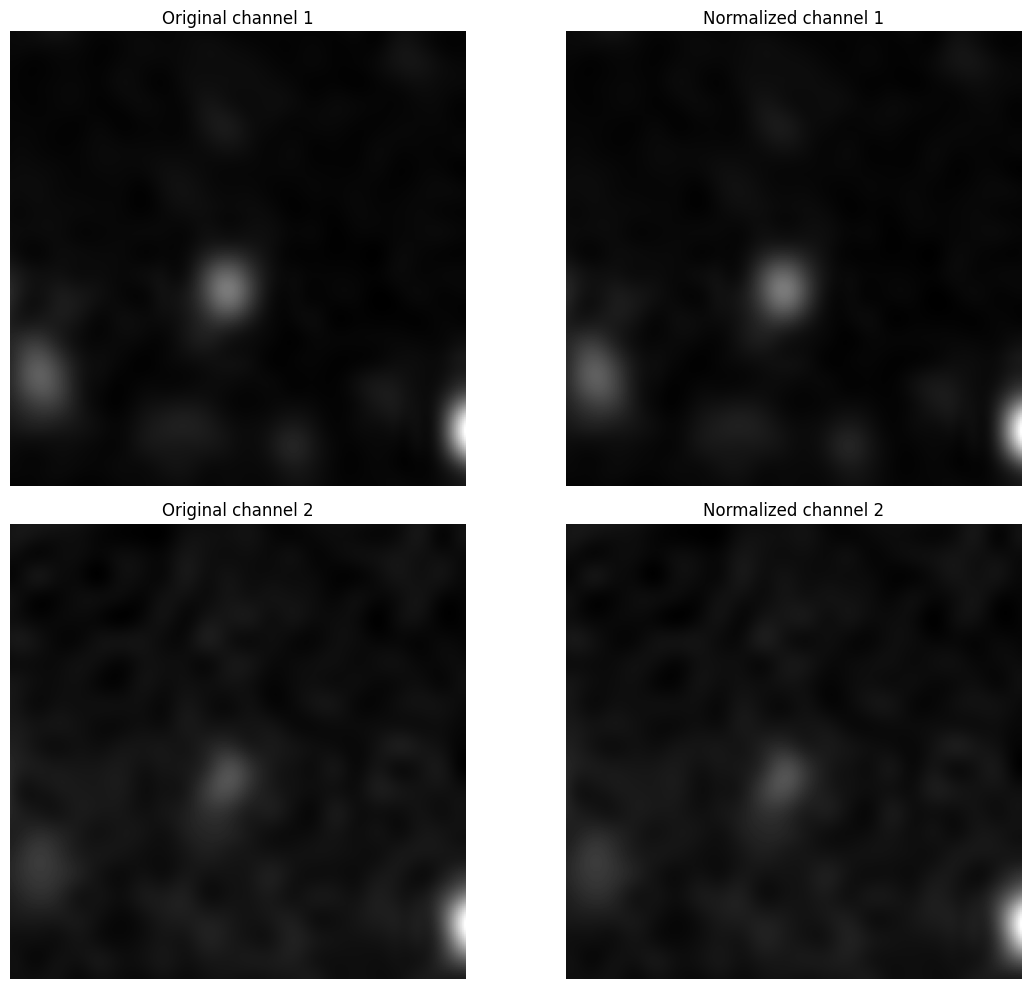

In [ ]:
print_imgs(img, normalized_image)

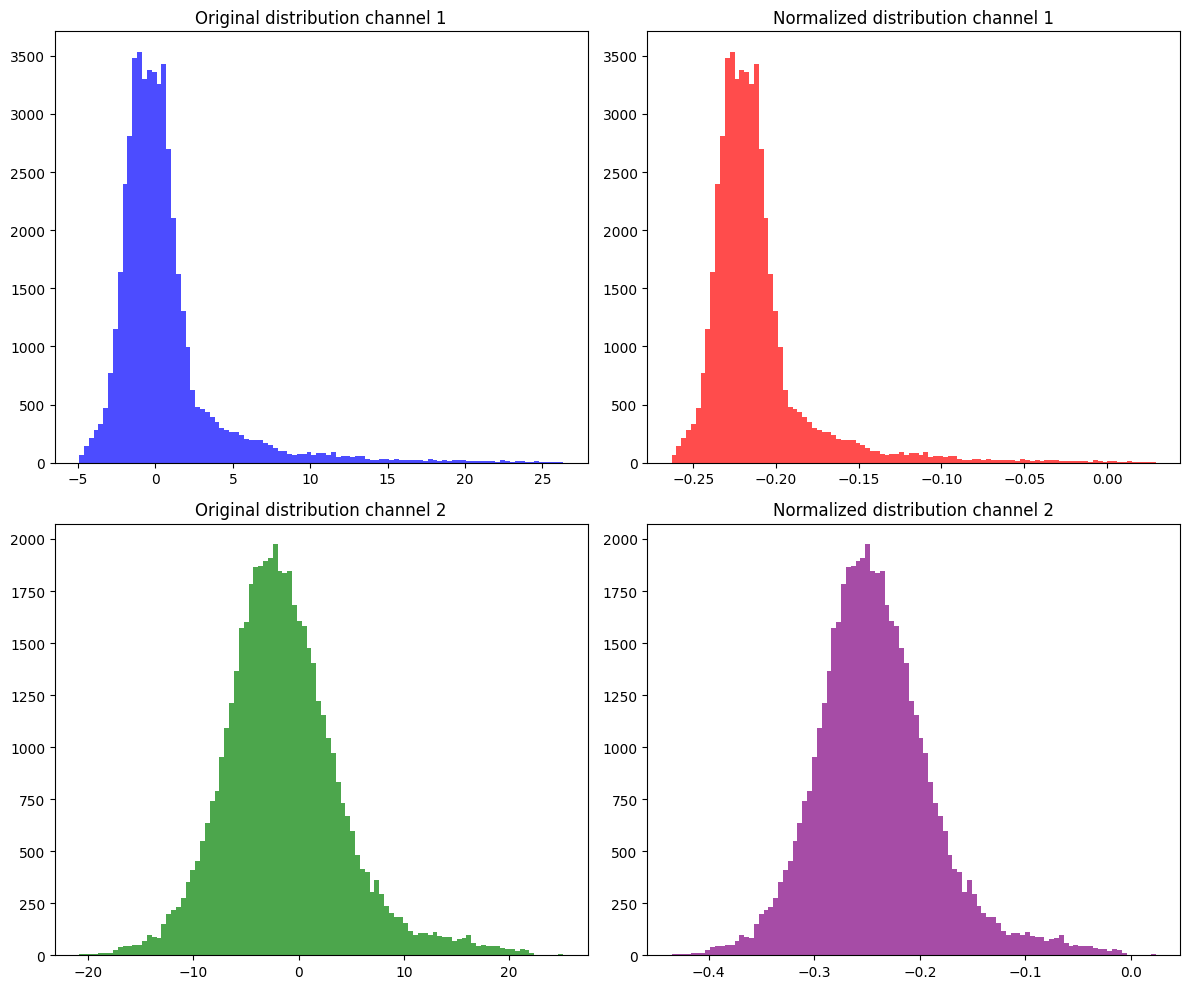

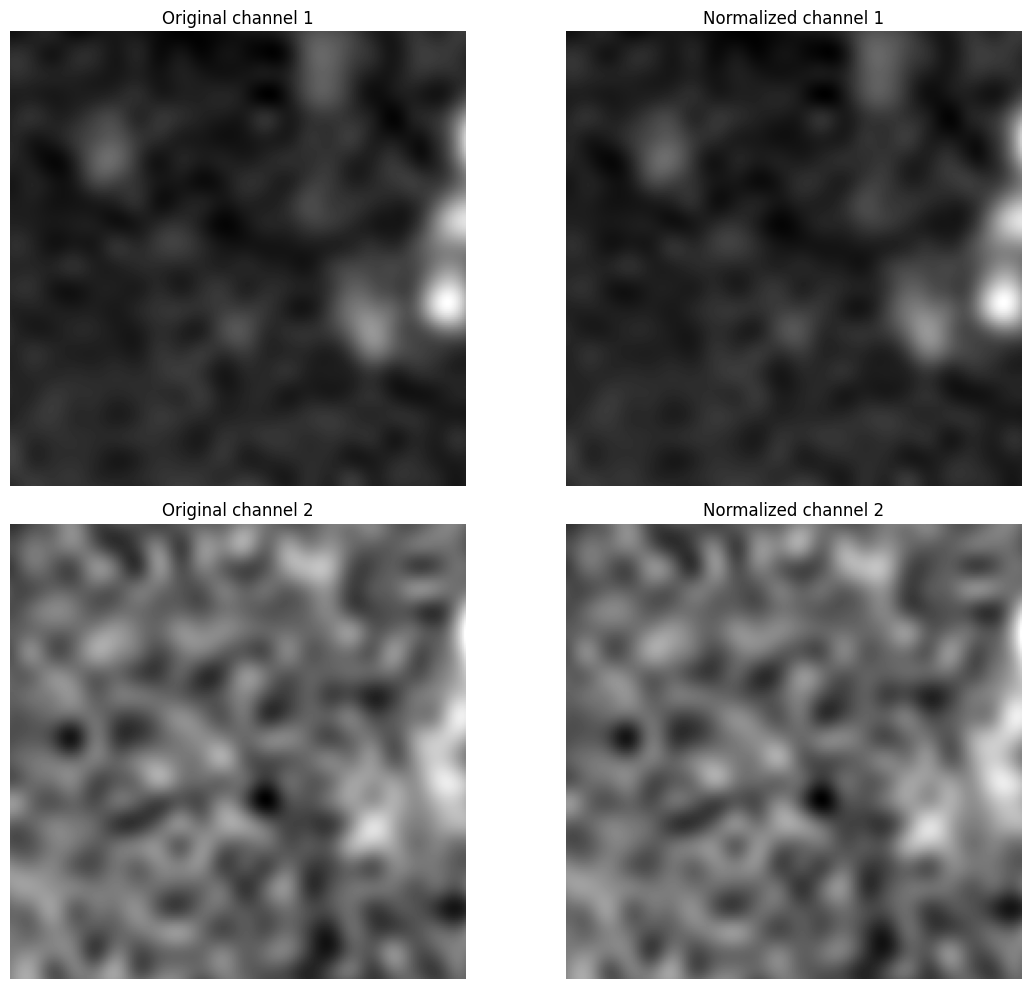

In [ ]:
channel_1, channel_2 = load_fits_channels(file_paths[99])
img = torch.stack([channel_1, channel_2])
normalized_image = transform(img)

print_distr(img, normalized_image)
print_imgs(img, normalized_image)